# Left Ventricle Full Quantification (LVQuan18) Challenge MICCAI 2018


Accurate cardiac left ventricle (LV) quantification is among the most clinically important and most frequently demanded tasks for identification and diagnosis of cardiac diseases and is of great interest in the research community of medical image analysis.
To explain what the challenge is about in the context of machine learning, I use the approach explained here:
https://machinelearningmastery.com/how-to-define-your-machine-learning-problem/.

It involves answering three questions:

### Problem description

In one sentence, we want a system that will find some information about the Left Ventricle (LV) out of cardiac images
to diagnose some heart diseases.

Tom Mitchell’s definition of a machine learning problem requires the definition of Tasks,
Experience and Performance. These terms are defined for this problem as follows:

* Tasks: Compute LV indices of each slice of patient cardiac SAX MR images. These indices are:

    1. Areas of LV cavity and myocardium : $A_{1}$ and $A_{2}$ (see Fig.1(a))
    2. Dimensions of LV cavity: $D_{1}, D_{2}$ and $D_{3}$ (see Fig.1(b))
    3. Reginal Wall Thickness of myocardium: $RWT_{1}, ..., RWT_{6}$ (see Fig.1(c))
    4. Cardiac phase (when images are acquired): diastole (0) or systole(1) (see Fig.1(d))
   
   <figure>
  <img src="lvquan.jpg" width="600">
  <figcaption> <center> Figure 1. LV indices to find. Orange and green areas are respectively LV cavity and myocardium.
  </center> </figcaption>
</figure>
   
    
* Experiences: A set of 145 anonymized patient cardiac SAX MR images with all 4 indices for each slice.


* Performance: Mean Absolute Error (MAE) to assess the performance of the method for estimation of indices 1,2 and 3. For the last indice, the Error Rate of the misclassified cardiac phase is used. Their formulae are:


$ MAE_{indice} = \frac{\sum_{i=1}^{N} \lvert Pred^{indice}_{i}  -  GT^{indice}_{i} \rvert }{N} $

$ER_{phase} = \frac{\sum_{i=1}^{N} Cardinal(Pred^{phase}_{i} \neq GT^{phase}_{i}) }{N} $

### The dataset provided

A training dataset with processed SAX MR sequences of 145 subjects from clinical environment is used for model learning and validation.

For each subject, 20 frames are included for the whole cardiac cycle. All ground truth values of the above-mentioned LV indices are provided for every single frame. More details about the training dataset can be found in the document of the DIG-Cardiac dataset. 


A complete information of the challenge can be found at: https://lvquan18.github.io/

References: 

[1]: Figure 1 from https://lvquan18.github.io/2018/03/12/objective.html

In [35]:
import numpy as np
from matplotlib import pyplot as plt
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
%matplotlib inline
%reload_ext autoreload
%autoreload 2

PATH ='./'

## Dataset exploration

The provided dataset is a matlab file (.mat). 

Thus we're going to use scipy.io which can open this kind of file in python.

In [116]:
import scipy.io as sio

data = sio.loadmat(PATH+'cardiac-dig.mat')
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'areas', 'dims', 'endo_LV', 'epi_LV', 'images_LV', 'lv_phase', 'pix_spa', 'ratio_resize_inverse', 'rwt'])

In [3]:
f'{data["images_LV"].shape}, 2900 / 20 frames =  {2900/20} patients'

'(80, 80, 2900), 2900 / 20 frames =  145.0 patients'

In [4]:
n_diastolic = np.sum(data["lv_phase"] == 0) // 20
n_systolic = np.sum(data["lv_phase"] == 1) // 20
print(f'Number of sequences in diastolic phase :  {n_diastolic}')
print(f'Number of sequences in systolic phase  :  {n_systolic}')
print(f'Total                                  : {n_diastolic + n_systolic}')


Number of sequences in diastolic phase :  84
Number of sequences in systolic phase  :  61
Total                                  : 145


### An analysis of the relation between LV cavity area and the phase

[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


Text(0,0.5,'Area of LV cavity')

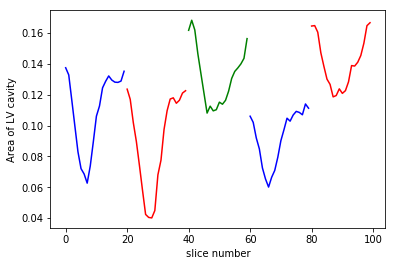

In [203]:
S = 20
k = 5
A = 0
for i in range(k):
    print(data['lv_phase'][0,i*S:(i+1)*S])
    
plt.plot(data['areas'][A,:S], 'b', range(S, 2*S), data['areas'][A,S:S+S], 'r',
        range(2*S, 3*S), data['areas'][A,2*S:3*S], 'g', 
        range(3*S, 4*S), data['areas'][A,3*S:4*S], 'b',
        range(4*S, 5*S), data['areas'][A,4*S:5*S], 'r')
plt.xlabel('slice number')
plt.ylabel('Area of LV cavity')

**Remark:**

It appears from the plot above that when the LV cavity area decreases, the phase is 1: Systole.

And, it equals 0 (diastole) when LV cavity increases. So one way to find the phase is to track
the LV cavity area

In [5]:
patient = data['images_LV'][:,:,:20]
seg_endo = data['endo_LV'][:,:,:20]
seg_epi = data['epi_LV'][:,:,:20]

def get_sample(seq, size=3):
    return np.hstack([seq[:,:,i] for i in range(size)])

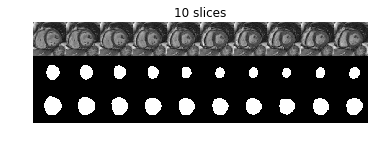

In [9]:
n = 10
slice_sample = get_sample(patient, n)
seg_endo_sample = get_sample(seg_endo, n)
seg_epi_sample = get_sample(seg_epi, n)
samples = np.vstack((slice_sample, seg_endo_sample, seg_epi_sample))
plt.imshow(samples, cmap='gray')
plt.title(f'{n} slices')
plt.axis("off")
plt.show()


In [81]:
print ('dims attribute', data['dims'].shape, data['dims'][:,0])
print ('areas attribute', data['areas'].shape, data['areas'][:,0])
print ('rwt attribute', data['rwt'].shape, data['rwt'][:,0])

dims attribute (3, 2900) [ 0.40795  0.4411   0.40617]
areas attribute (2, 2900) [ 0.13742  0.09059]
rwt attribute (6, 2900) [ 0.06005  0.04753  0.05253  0.05125  0.04902  0.06165]


## Visualization of endocardium and epicardium

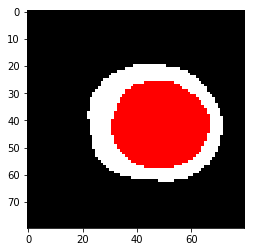

In [167]:
red  = (255, 0, 0) #np.array([255, 0, 0], dtype=np.uint8)
green = (0, 255, 0) #np.array([0, 255, 0], dtype=np.uint8)
blue   = (0, 0, 255) 
def overlay(im, mask, color):
    overlaid = im.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if (mask[i,j] > 100).all():
                overlaid[i,j] = color
    return overlaid

pat_endo = data['endo_LV'][:,:,200]
pat_endo = make_cv2_compatible(pat_endo)
pat_epi = data['epi_LV'][:,:,200]
pat_epi = make_cv2_compatible(pat_epi)
both = overlay(pat_epi, pat_endo, red)
plt.imshow(both)



## Compute Bounding Boxes of endocardium and epicardium segments

(80, 80, 3)
1
(22, 20, 50, 43)


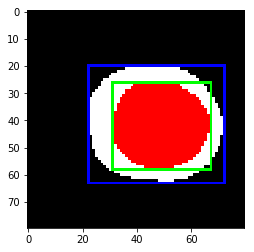

In [169]:
import cv2

def make_cv2_compatible(img, cmap='gray'):
    plt.imsave("tmp.jpg", img, cmap=cmap )
    im = cv2.imread('tmp.jpg')
    return im

def min_max(x):
    return np.min(x), np.max(x)


def meth1(pat):
    xs, ys = np.where(pat==1)
    min_x, max_x = min_max(xs)
    min_y, max_y = min_max(ys)
    # points = [[xs[i], ys[i]] for i in [min_x, max_x, min_y, max_y]]
    points = np.array([[min_y,min_x], [max_y,max_x]])
    return  cv2.boundingRect(points)
 
def get_bb(pat):
    im = make_cv2_compatible(pat)
    ctrs= cv2.findContours( cv2.cvtColor(im, cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )[1]
    return cv2.boundingRect(ctrs[0])
    
pat = data['epi_LV'][:,:,200]




xs, ys = np.where(pat==1)

min_x, max_x = min_max(xs)
min_y, max_y = min_max(ys)
# points = [[xs[i], ys[i]] for i in [min_x, max_x, min_y, max_y]]
points = np.array([[min_y,min_x], [max_y,max_x]])
# seg_endo[:,:,0][22,39]
pat = make_cv2_compatible(pat)
print(pat.shape)
ctrs= cv2.findContours( cv2.cvtColor(pat, cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )[1]
print(len(ctrs))
(x, y, w, h) = cv2.boundingRect(points)
print((x, y, w, h))
cv2.rectangle(both,(x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(both)

In [158]:
n = data["images_LV"].shape[-1]
print(data['endo_LV'].shape,n)
endo_bb = [meth1(data['endo_LV'][:,:,i]) for i in range(n)]
epi_bb = [meth1(data['epi_LV'][:,:,i]) for i in range(n)]

(80, 80, 2900) 2900
